# How metric scores change over time? 

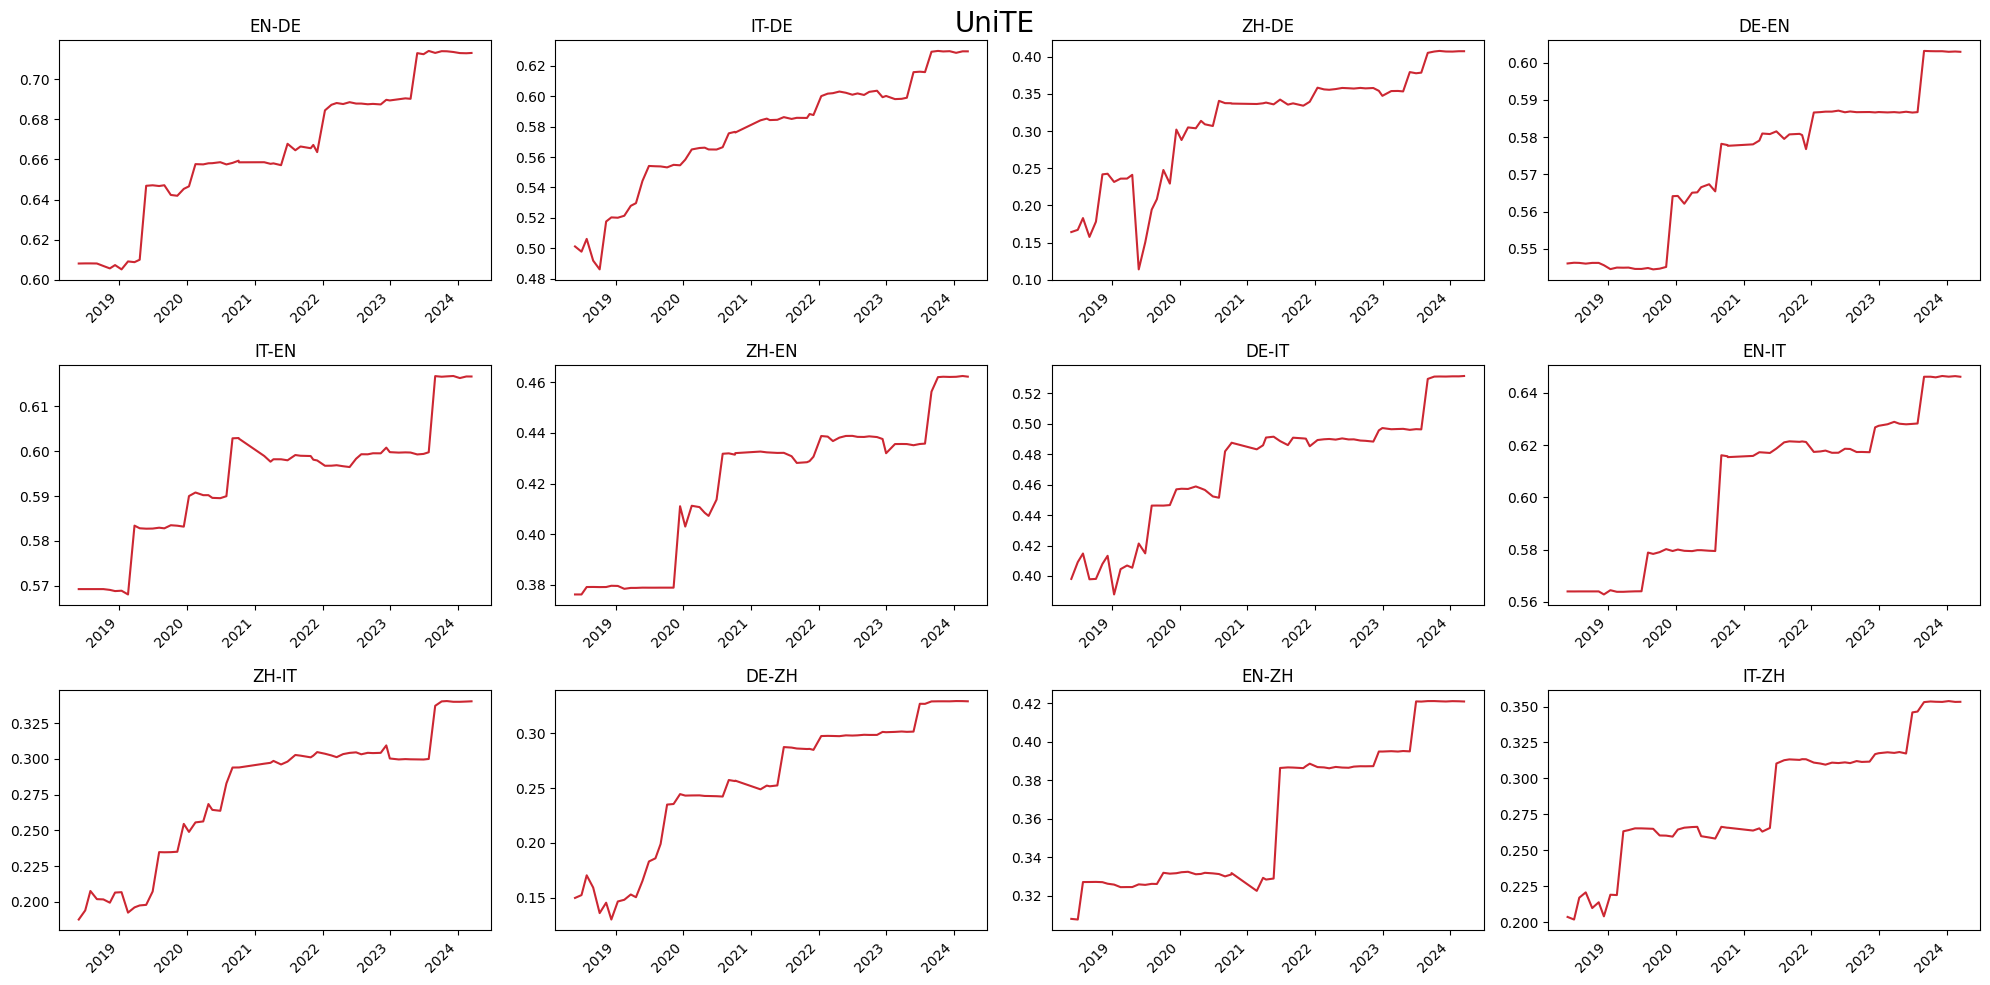

In [1]:
# Scores over time
# This script plots the scores over time for each language pair in a subplot
import pandas as pd
from evaluation.SETTINGS import *

# set the metric to plot
# ['comet22', 'unite', 'comet20', 'cometkiwi','mscomet22qe', 'bert', 'bleu', 'chrf']
metric = 'unite'
score_path = f'result/sys_{metric}.csv'
score_df = pd.read_csv(score_path, sep=',')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))

for i, ax in enumerate(axes.flatten()):
    lp = lps[i]
    scores = score_df[lp]
    dates = score_df['date']

    df = pd.DataFrame({'date': dates, 'score': scores})
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    
    df.plot(ax=ax, color=colors[metric], legend=False)
    ax.set_title(f'{lp.upper()}')
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_xlabel(None)

fig.suptitle(metric_dict[metric], fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()


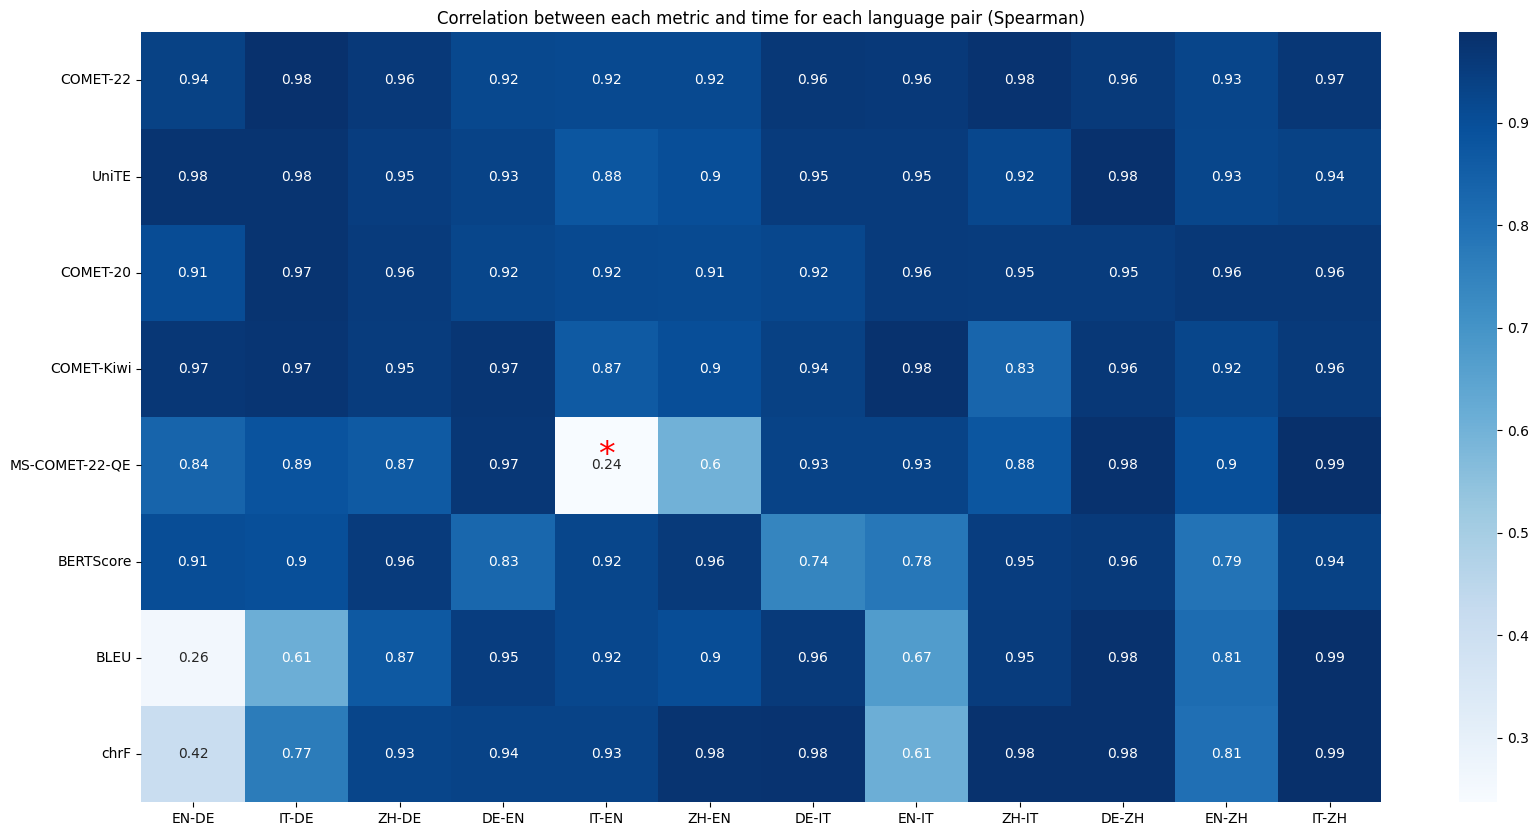

In [1]:
# Spearman correlation
import pandas as pd
from evaluation.SETTINGS import *
from evaluation.util import *

correlations = pd.DataFrame()
path = 'result/'
corr = spearman
for lp in lps:
        df = get_metrics_per_lp(path, lp)
        
        corr_list = []
        
        # calculate the correlation between each metric and time
        for metric in metrics:
                corr_list.append(corr(df[metric]))

        correlations[lp] = corr_list

plot_heatmap(correlations, 'Spearman')

# Overall

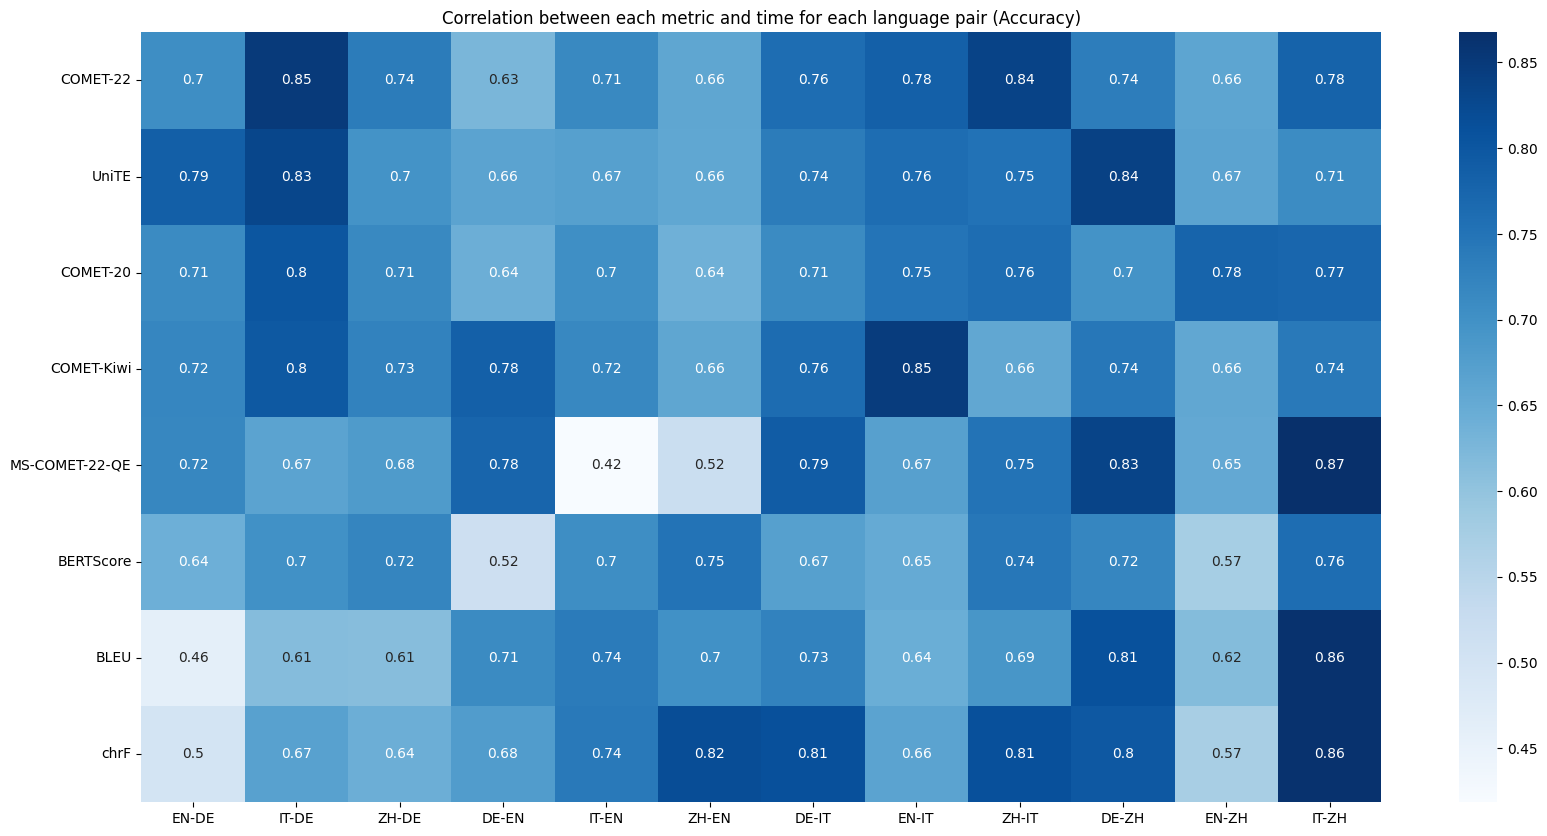

In [2]:
import pandas as pd
from evaluation.SETTINGS import *
from evaluation.util import *

correlations = pd.DataFrame()
path = 'result/'
corr = acc
for lp in lps:
        df = get_metrics_per_lp(path, lp)
        
        corr_list = []
        
        # calculate the correlation between each metric and time
        for metric in metrics:
                equals = corr(df[metric], gap = 11)
                corr_list.append(np.sum(equals)/len(equals))

        correlations[lp] = corr_list

plot_heatmap(correlations, 'Accuracy')


# correlation between metrics for all the systems 

In [10]:
import numpy as np
# with time gap 
def corr(x, y, time_gap):
    # for each pair in x, calculate the sign of their difference
    diff_x, diff_y = [], []
    for i in range(len(x)-1):
        for j in range(i+1, min(i+time_gap+1, len(x))):
            diff_x.append(np.sign(x[j] - x[i])) 
            diff_y.append(np.sign(y[j] - y[i]))
    # calculate the correlation between the signs
    # it should be the number of pairs with the same sign divided by the total number of pairs
    
    return np.sum(np.equal(diff_x, diff_y)) / len(diff_x)

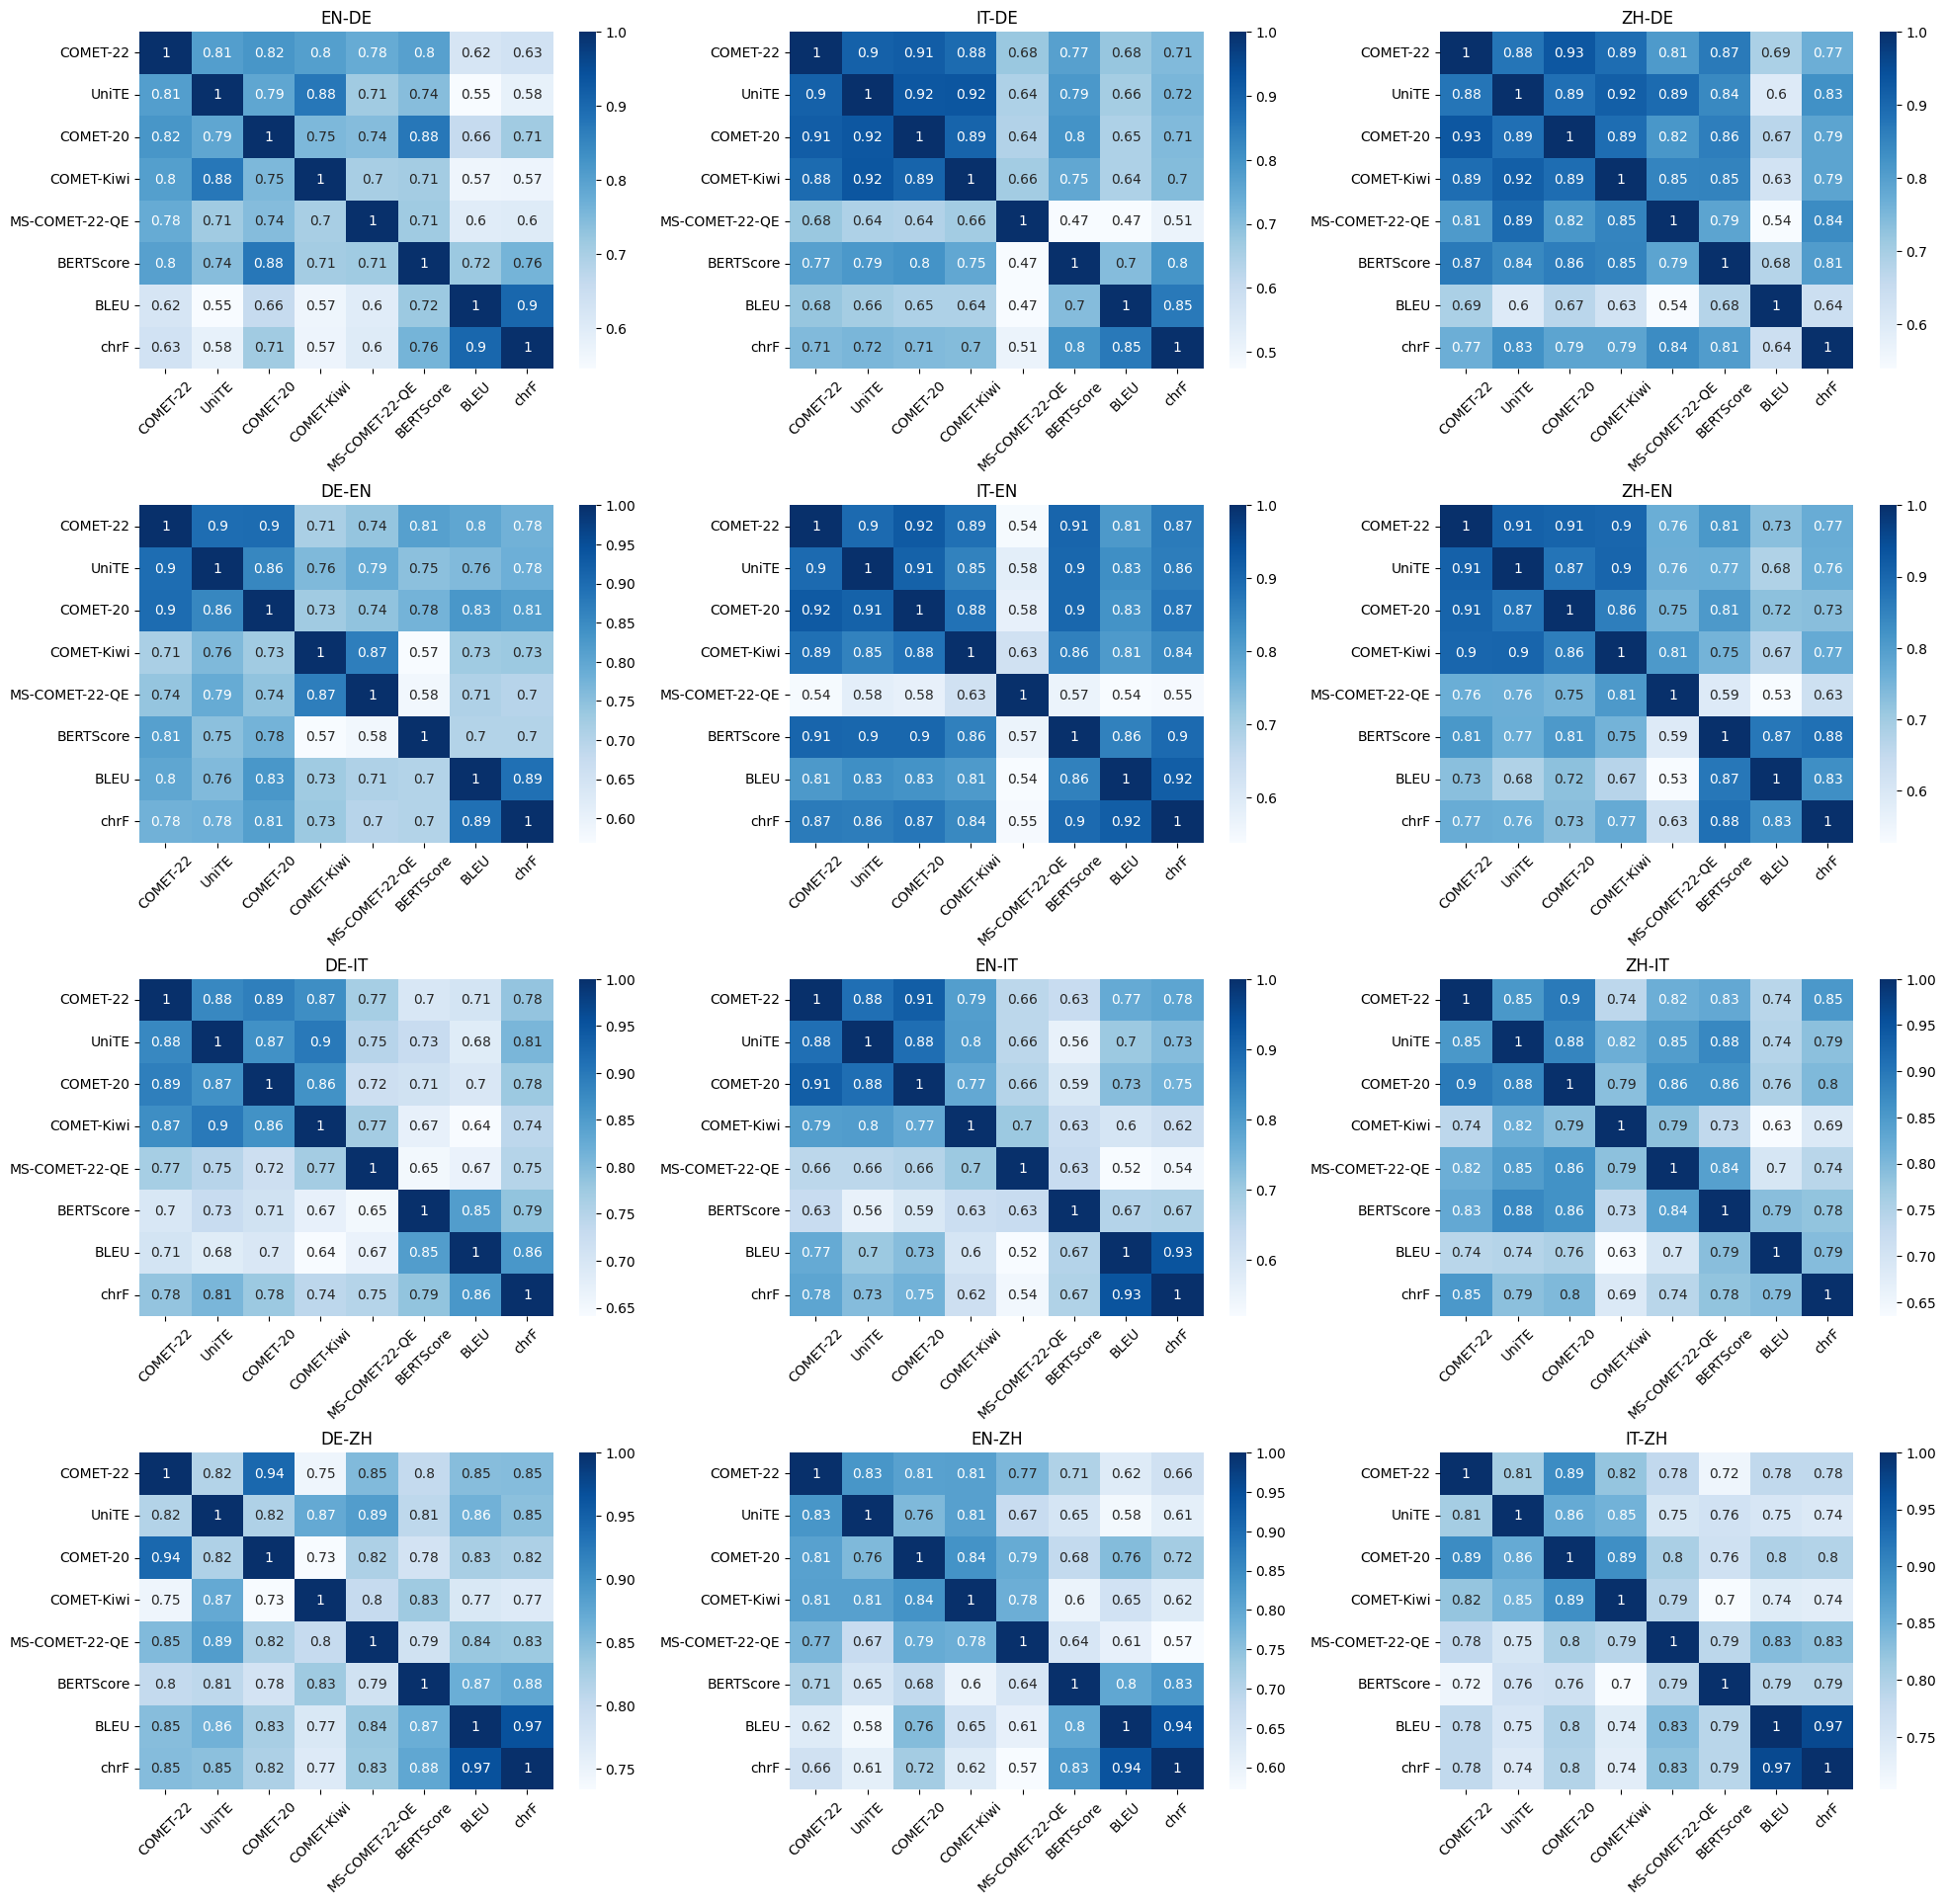

In [11]:
import pandas as pd
import numpy as np
from evaluation.SETTINGS import *
from evaluation.util import get_metrics_per_lp


# dict to store the correlation matrix for each lp
correlation_matrices = {}
for lp in lps:
        df = get_metrics_per_lp(lp)
                
        corr_matrix = pd.DataFrame(np.zeros((len(metrics), len(metrics))), columns=metrics, index=metrics)
        
        # calculate the correlation between each pair of metrics, there is no need to compute the same pairs twice
        for i in range(len(metrics)):
                for j in range(i, len(metrics)):
                        corr_matrix.iloc[i, j] = corr(df[metrics[i]], df[metrics[j]], 11)

        # fill the lower triangle of the matrix
        corr_matrix = corr_matrix + corr_matrix.T - np.diag(np.diag(corr_matrix))
        correlation_matrices[lp] = corr_matrix
        
# visualize the correlation matrix for each lp
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
for lp in lps:
        # do not plot the diagonal
        # replace the metric names with metric_dict
        correlation_matrices[lp].columns = [metric_dict[metric] for metric in metrics]
        correlation_matrices[lp].index = [metric_dict[metric] for metric in metrics]
        sns.heatmap(correlation_matrices[lp], annot=True, ax=axes.flatten()[lps.index(lp)], cmap='Blues')
        axes.flatten()[lps.index(lp)].set_title(f'{lp.upper()}')
        axes.flatten()[lps.index(lp)].set_xlabel(None)
        axes.flatten()[lps.index(lp)].set_ylabel(None)
        # rotate the xticks
        axes.flatten()[lps.index(lp)].tick_params(axis='x', labelrotation=45)
        
# set the title of the figure
# fig.suptitle('Correlation Matrix', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

# show the figure
plt.show()

# correlation with gold standard and rolling window

In [5]:
import numpy as np
from scipy.stats import spearmanr

def acc(x):
    gap = 11
    y = list(range(1, len(x)+1))
    # for each pair in x, calculate the sign of their difference 
    diff_x, diff_y = [], []
    for i in range(len(x)-1):
        for j in range(i+1, min(i+gap+1, len(x))):
            diff_x.append(np.sign(x[j] - x[i])) 
            diff_y.append(np.sign(y[j] - y[i]))
    # calculate the correlation between the signs
    # it should be the number of pairs with the same sign divided by the total number of pairs
    correct = np.sum(np.equal(diff_x, diff_y))
    total = len(diff_x)
    
    return  correct / total

def pearson(x):
    y = list(range(1, len(x)+1))
    return np.corrcoef(x, y)[0, 1]

def spearman(x):
    y = list(range(1, len(x)+1))
    return spearmanr(x, y)[0]

corr_dict = {'Accuracy': acc, 'Pearson': pearson, 'Spearman': spearman}
corr_name = 'Spearman'
# assign the function to calculate the correlation
corr = corr_dict[corr_name]


# window

In [29]:
# rolling window
import pandas as pd

sample_size = 36
# dict to store correlation between each metric and time 
correlations = {}

for lp in lps:
        df = get_metrics_per_lp(lp)
        
        # calculate the correlation between each metric and time
        for metric in metrics:
                corr_list = []
                # calculate the correlation between each metric and time with a rolling window
                for sample in df[metric].rolling(sample_size):
                        if len(sample) != sample_size:
                                continue
                        corr_list.append(corr(sample.values))
                correlations[(lp, metric)] = corr_list
        
        # corr_list = []
        # for sample in df.rolling(sample_size):
                
        #         if len(sample) != sample_size:
        #                 continue
        #         acc = vote(sample, voters)
        #         corr_list.append(acc)
        # correlations[(lp, 'vote')] = corr_list

## across lps

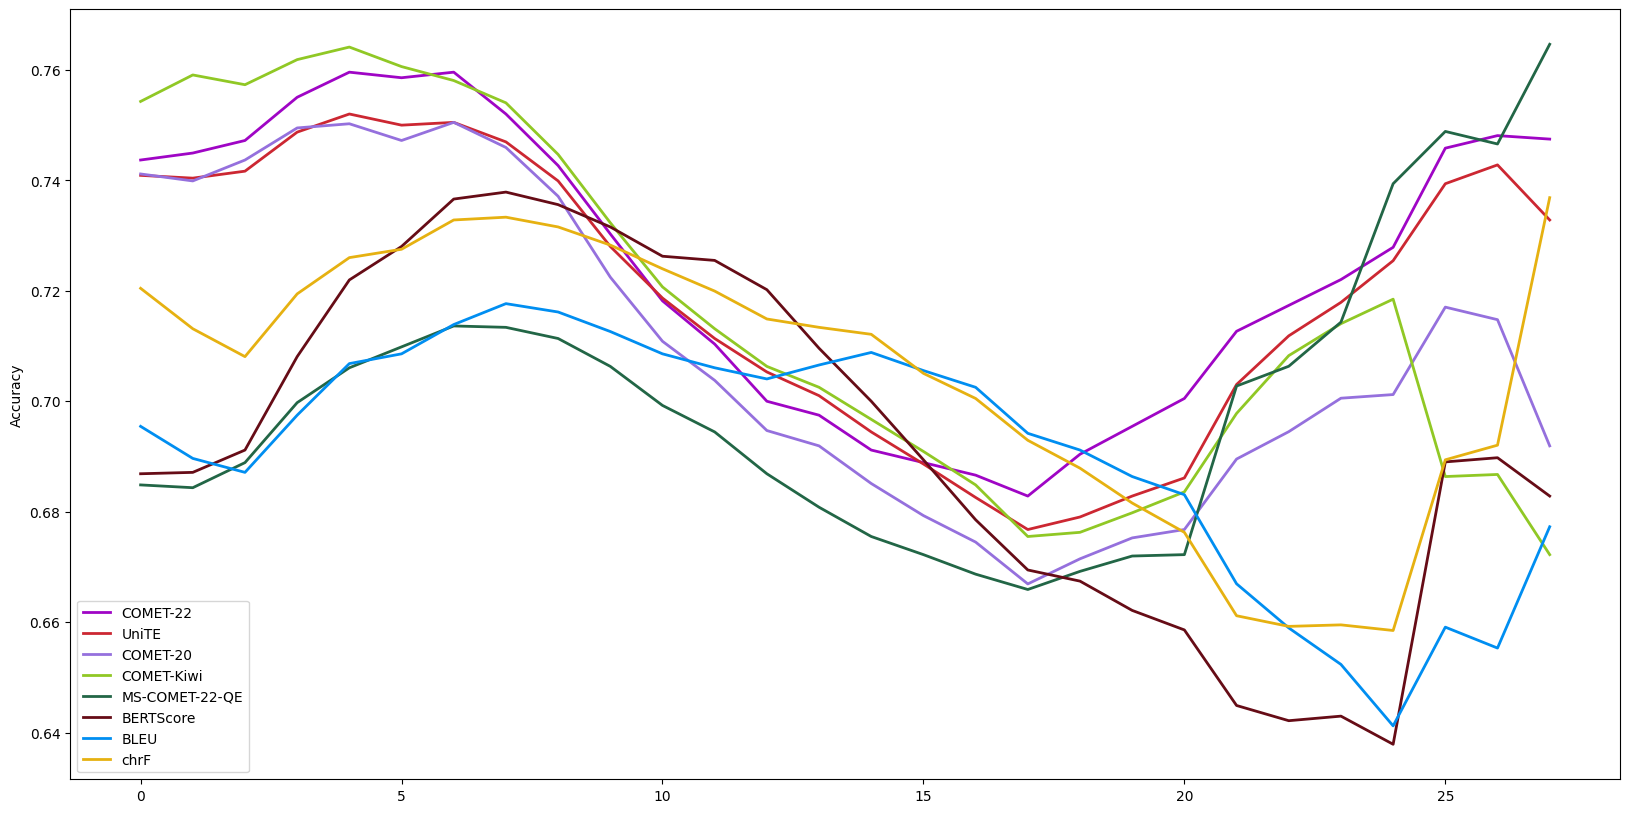

In [30]:
# average the correlations across lps
all_corr = pd.DataFrame()
# metrics = voters + ['vote']
for metric in metrics:
        all_corr[metric] = pd.DataFrame([correlations[(lp, metric)] for lp in lps]).mean(axis=0)

colors = {'mscomet22qe': '#226646', 'comet22': '#9F05C5', 'bert': '#660C16', 'unite': '#CC2732',
        'comet20': '#9570DD', 'cometkiwi': '#90C825', 'bleu': '#008EF1', 'chrf': '#E6B111', 'vote': '#000000'}
# plot the correlation between each metric and time in line chart
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(20, 10))

for metric in metrics:
        ax.plot(all_corr[metric], label=metric, color=colors[metric], linewidth=2)

# ax.set_title(corr_name + ' between each metric and time', fontsize=20)
# ax.set_xlabel('Step')
ax.set_ylabel(corr_name)
# replace metric names with their full names in the legend
ax.legend([metric_dict[metric] for metric in metrics])
# show the figure
plt.show()

## across time

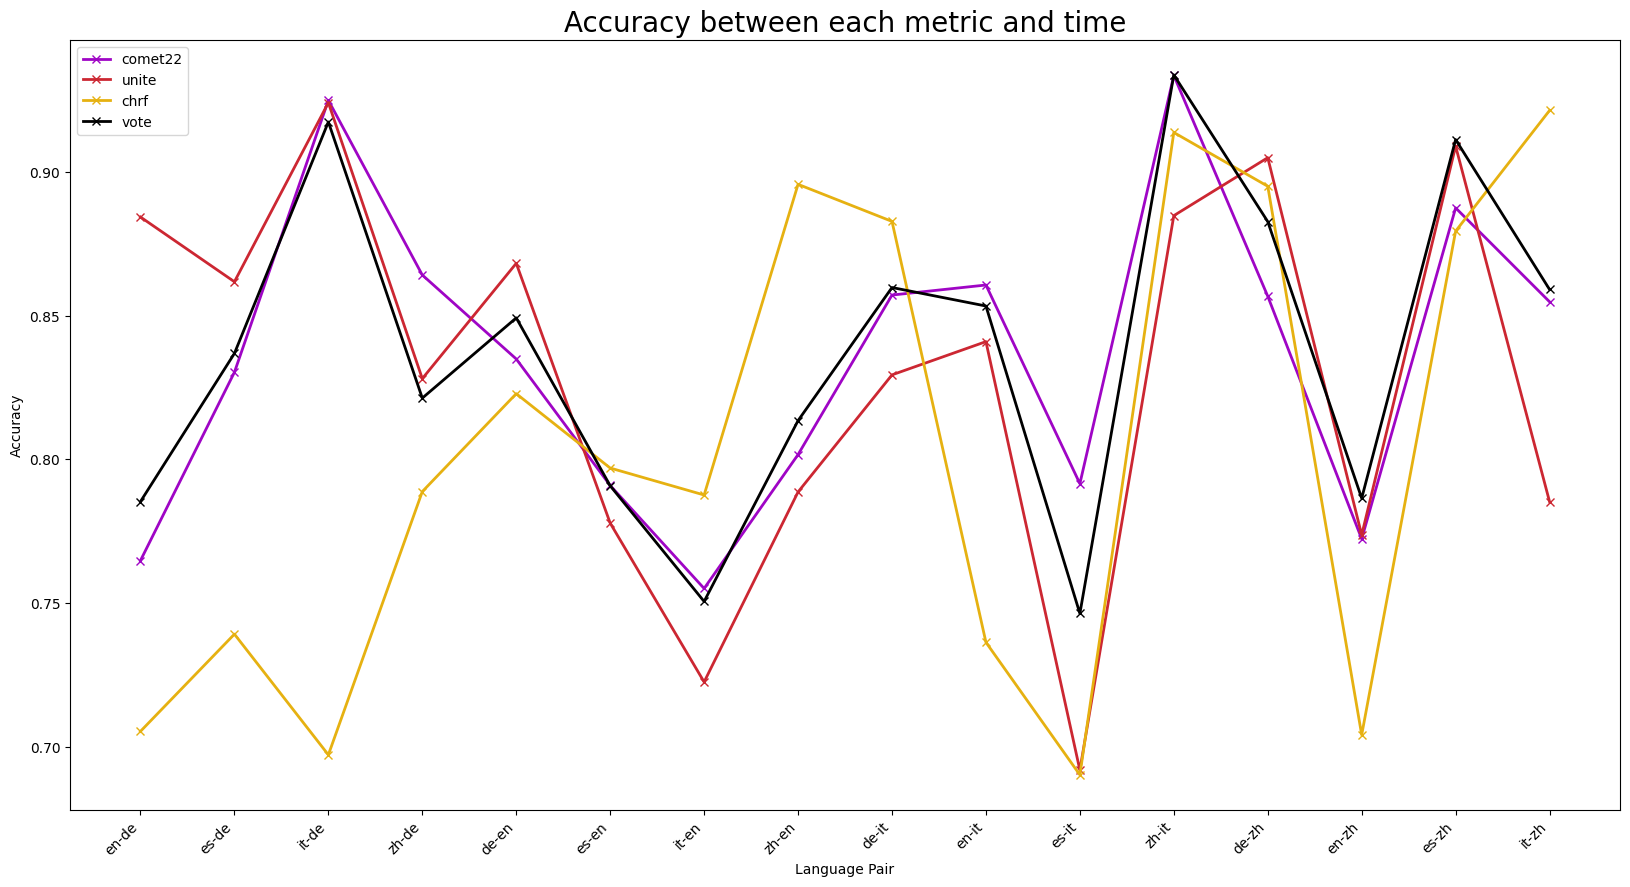

In [70]:
df = pd.DataFrame()

for metric in metrics:
        df[metric] = pd.DataFrame([correlations[(lp, metric)] for lp in lps]).mean(axis=1)

# plot the correlation between each metric and time in line chart
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(20, 10))
for metric in metrics:
        ax.plot(df[metric], label=metric, color=colors[metric], linewidth=2, marker='x')
# Set x-ticks and labels
ax.set_xticks(range(len(lps)))
ax.set_xticklabels(lps, rotation=45, ha='right')

ax.set_title(corr_name + ' between each metric and time', fontsize=20)
ax.set_xlabel('Language Pair')
ax.set_ylabel(corr_name)
ax.legend()

# Show the figure
plt.show()

## lps

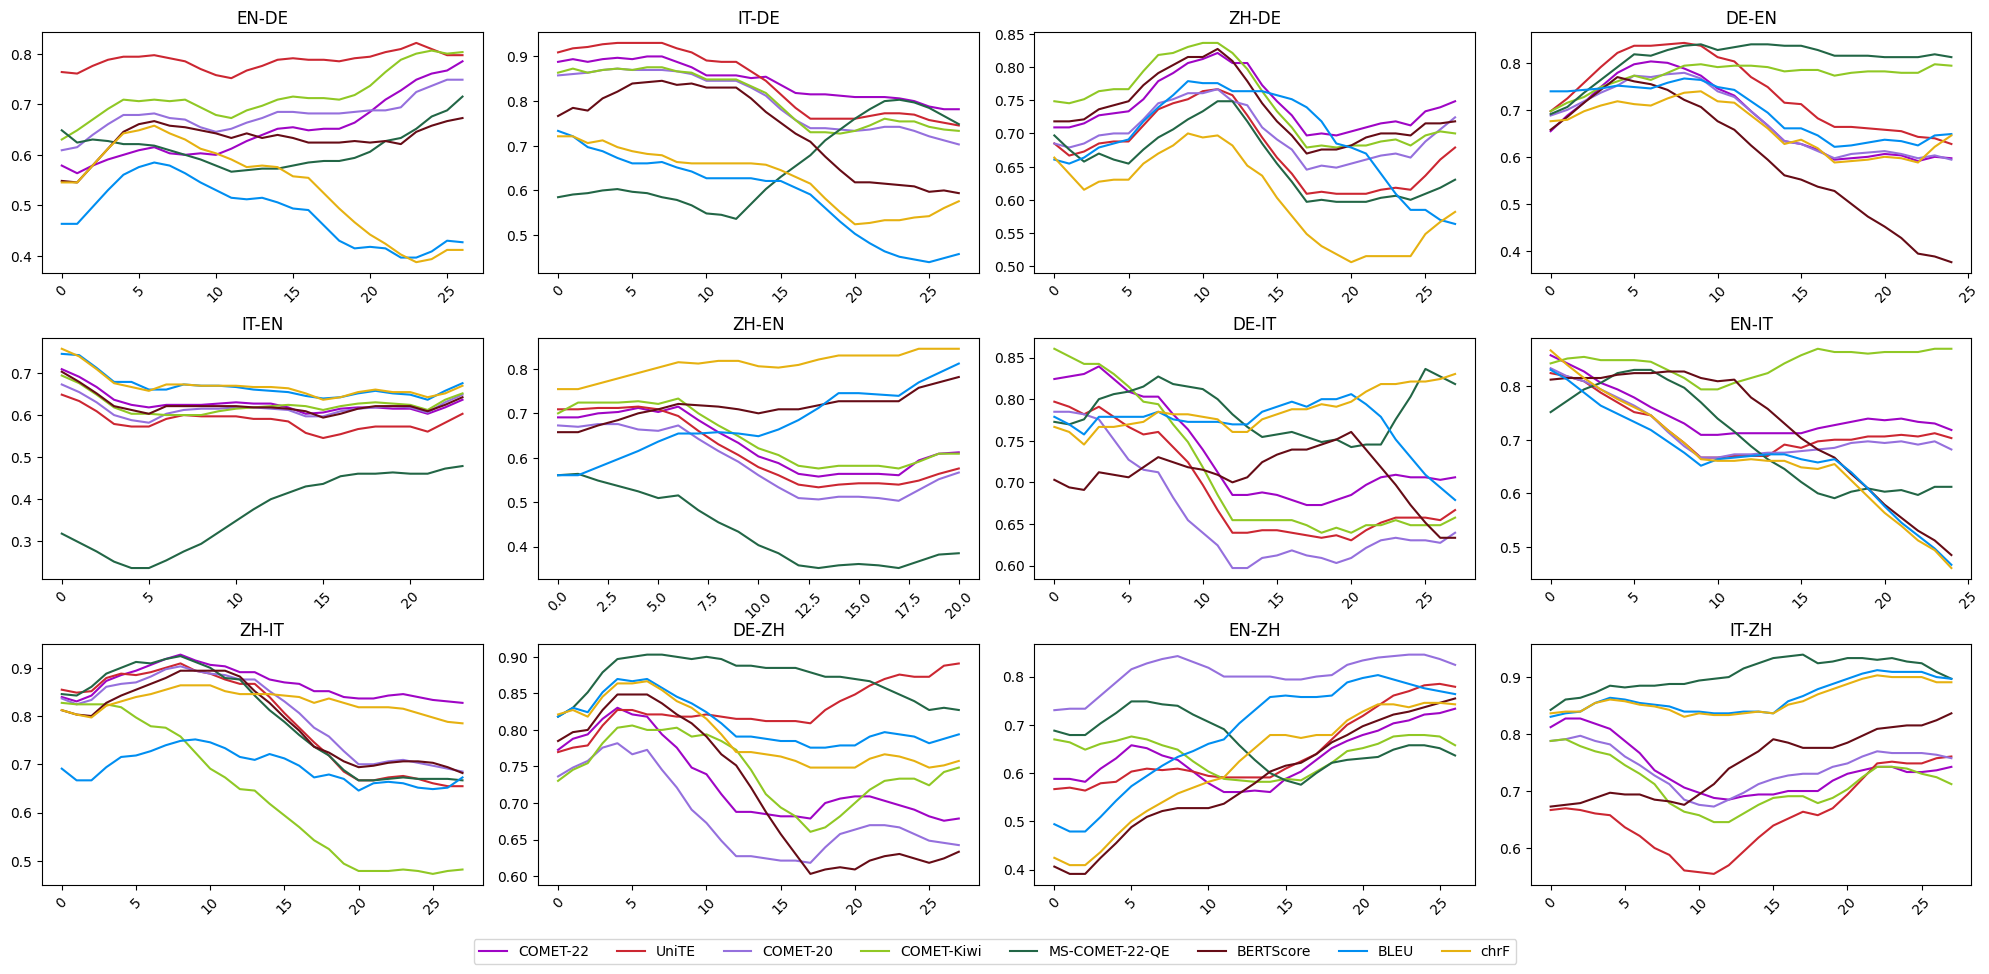

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the correlation between each metric and time in one line plot

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
        lp = lps[i]
        for metric in metrics:
                ax.plot(correlations[(lp, metric)], label=metric, color=colors[metric]) 
        ax.set_title(f'{lp.upper()}')
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.tick_params(axis='x', labelrotation=45)
# set the title of the figure
# fig.suptitle(corr_name + ' between each metric and time', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.legend([metric_dict[metric] for metric in metrics], loc='upper center', bbox_to_anchor=(0.5, 0), ncol=10)

# show the figure
plt.show()

# show of hands

In [5]:
def vote(df, metrics):
    x = df.shape[0]
    y = list(range(1, x+1))
    gap = 11

    diff_x, diff_y = [], []

    for i in range(x-1):
        for j in range(i+1, min(i+gap+1, x)):
            votes = 0
            for metric in metrics:
                votes += np.sign(df[metric].values[j] - df[metric].values[i])
            diff_x.append(np.sign(votes))
            diff_y.append(np.sign(y[j] - y[i]))

    return  np.equal(diff_x, diff_y)
            

In [7]:
import pandas as pd
import numpy as np
from evaluation.SETTINGS import *
from evaluation.util import *

def vote_for_comb(voters):
        correct = 0
        total = 0

        lp_acc = {}

        for lp in lps:
                df = get_metrics_per_lp(lp)
                votes = vote(df, voters)
                correct += np.sum(votes)
                total += len(votes)
                print(f'{lp}: {np.sum(votes) / len(votes)}')
                lp_acc[lp] = np.sum(votes) / len(votes)

        acc = correct / total
        return acc, lp_acc

en-de: 0.6363636363636364
it-de: 0.8006379585326954
zh-de: 0.7416267942583732
de-en: 0.7861952861952862
it-en: 0.7015437392795884
zh-en: 0.6563636363636364
de-it: 0.8596491228070176
en-it: 0.8535353535353535
zh-it: 0.7543859649122807
de-zh: 0.8452950558213717
en-zh: 0.724025974025974
it-zh: 0.8580542264752791
en-de: 0.6542207792207793
it-de: 0.8054226475279107
zh-de: 0.6682615629984051
de-en: 0.7811447811447811
it-en: 0.7066895368782161
zh-en: 0.6690909090909091
de-it: 0.861244019138756
en-it: 0.8552188552188552
zh-it: 0.7607655502392344
de-zh: 0.8373205741626795
en-zh: 0.7175324675324676
it-zh: 0.8532695374800638
en-de: 0.663961038961039
it-de: 0.8038277511961722
zh-de: 0.7288676236044657
de-en: 0.7053872053872053
it-en: 0.6981132075471698
zh-en: 0.6745454545454546
de-it: 0.8149920255183413
en-it: 0.8569023569023569
zh-it: 0.7719298245614035
de-zh: 0.8452950558213717
en-zh: 0.7353896103896104
it-zh: 0.8564593301435407
en-de: 0.6363636363636364
it-de: 0.8197767145135566
zh-de: 0.730462

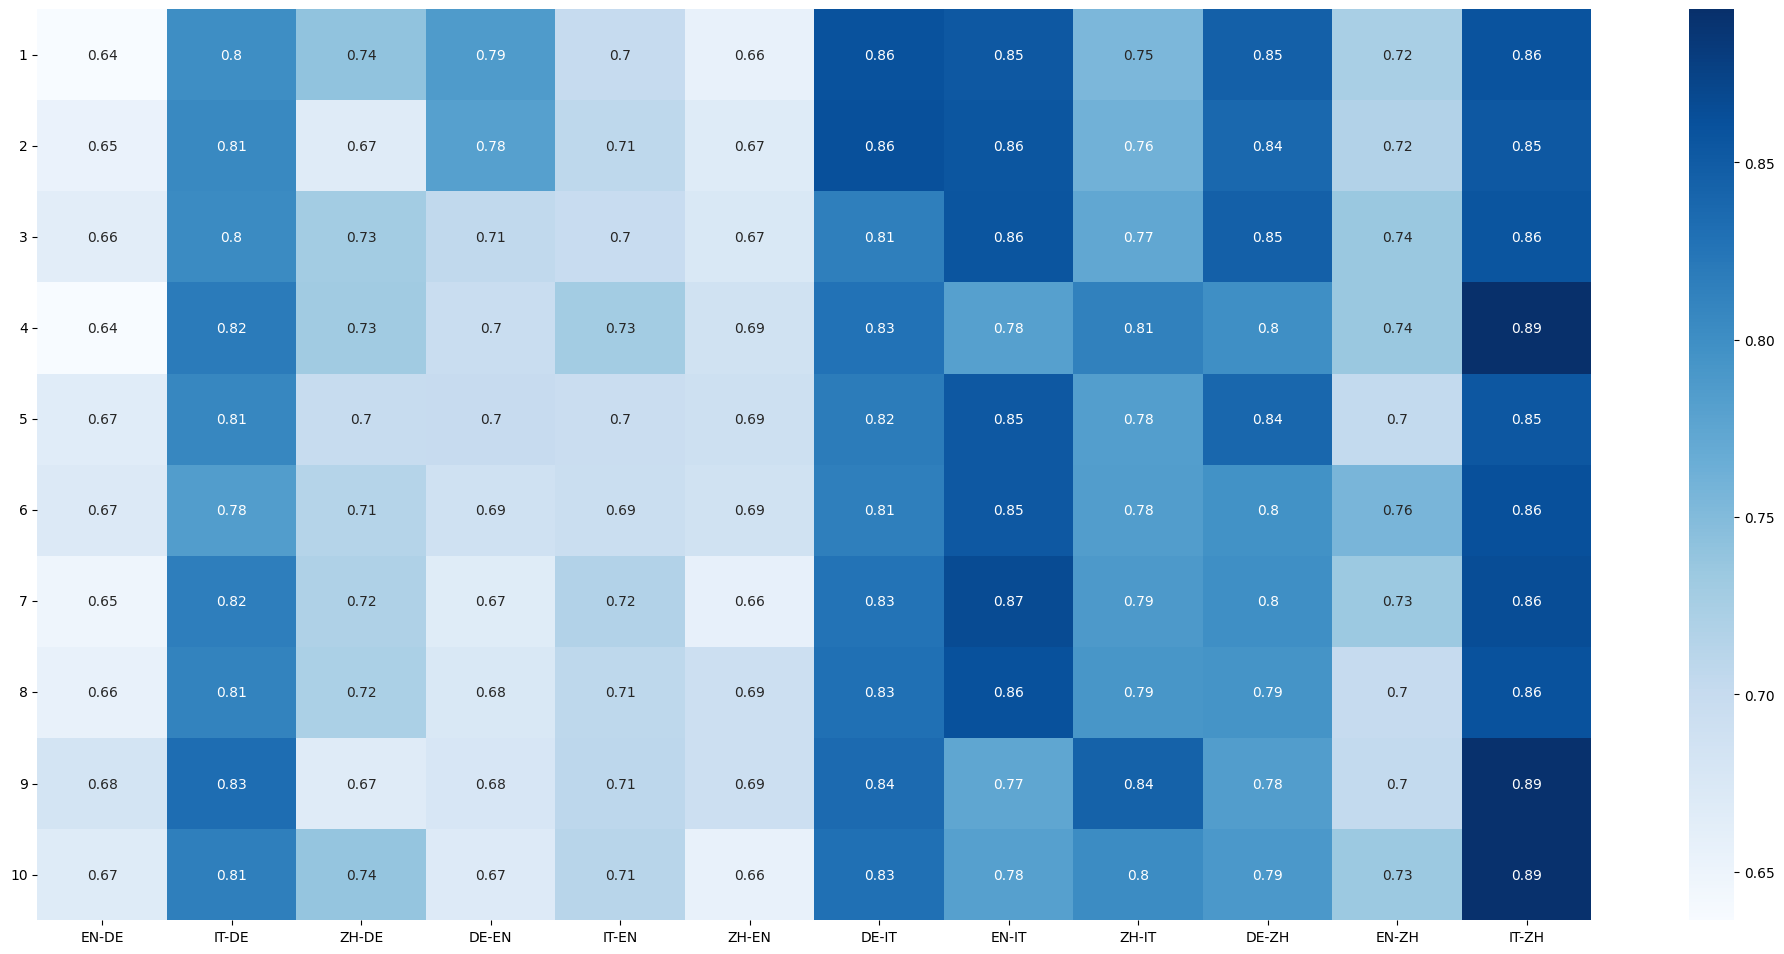

In [10]:
# for the following comb, get the lp_acc and plot a heatmap for the lp_acc, the rows are the lps, the columns are the combs
## generate all the combinations of the metrics
# (('cometkiwi', 'mscomet22qe', 'bleu'), 0.7695146958304853)
# (('cometkiwi', 'mscomet22qe', 'chrf'), 0.7652768284347232)
# (('unite', 'cometkiwi', 'mscomet22qe', 'bert', 'bleu'), 0.7643198906356801)
# (('comet22', 'cometkiwi', 'mscomet22qe', 'bleu', 'chrf'), 0.7639097744360902)
# (('unite', 'cometkiwi', 'mscomet22qe', 'bert', 'chrf'), 0.7603554340396446)
# (('comet20', 'cometkiwi', 'mscomet22qe', 'bert', 'chrf'), 0.7602187286397812)
# (('comet22', 'cometkiwi', 'mscomet22qe', 'bert', 'bleu'), 0.760082023239918)
# (('comet22', 'cometkiwi', 'mscomet22qe', 'bert', 'chrf'), 0.759671907040328)
# (('comet22', 'mscomet22qe', 'chrf'), 0.7595352016404648)
# (('comet22', 'mscomet22qe', 'bleu'), 0.7591250854408749)

combs = [('cometkiwi', 'mscomet22qe', 'bleu'), ('cometkiwi', 'mscomet22qe', 'chrf'),
        ('unite', 'cometkiwi', 'mscomet22qe', 'bert', 'bleu'), ('comet22', 'cometkiwi', 'mscomet22qe', 'bleu', 'chrf'),
        ('unite', 'cometkiwi', 'mscomet22qe', 'bert', 'chrf'), ('comet20', 'cometkiwi', 'mscomet22qe', 'bert', 'chrf'),
        ('comet22', 'cometkiwi', 'mscomet22qe', 'bert', 'bleu'), ('comet22', 'cometkiwi', 'mscomet22qe', 'bert', 'chrf'),
        ('comet22', 'mscomet22qe', 'chrf'), ('comet22', 'mscomet22qe', 'bleu')]
lp_accs = {}
for comb in combs:
        acc, lp_acc = vote_for_comb(comb)
        lp_accs[comb] = lp_acc

import matplotlib.pyplot as plt
import seaborn as sns
# plot the heatmap for the lp_acc
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(pd.DataFrame(lp_accs).T, annot=True, ax=ax, cmap='Blues')

# set x ticks upper case
ax.set_xticklabels([lp.upper() for lp in lps])
# set y ticks with the combed number in the order of the combs
ax.set_yticklabels([str(i+1) for i in range(len(combs))], rotation=0)

# set y label
ax.set_ylabel(None)
# set the title of the figure
# fig.suptitle('Accuracy for each combination', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

# show the figure
plt.show()




In [57]:
# generate all the combinations of the metrics
metrics = ['comet22', 'unite', 'comet20', 'cometkiwi','mscomet22qe', 'bert', 'bleu', 'chrf']
from itertools import combinations
combs = []
for i in range(1, len(metrics)+1):
    combs.extend(combinations(metrics, i))

# calculate the accuracy for each combination
accs = {}
for comb in combs:
    print(comb)
    acc = vote_for_comb(comb)
    accs[comb] = acc
accs

('comet22',)
('unite',)
('comet20',)
('cometkiwi',)
('mscomet22qe',)
('bert',)
('bleu',)
('chrf',)
('comet22', 'unite')
('comet22', 'comet20')
('comet22', 'cometkiwi')
('comet22', 'mscomet22qe')
('comet22', 'bert')
('comet22', 'bleu')
('comet22', 'chrf')
('unite', 'comet20')
('unite', 'cometkiwi')
('unite', 'mscomet22qe')
('unite', 'bert')
('unite', 'bleu')
('unite', 'chrf')
('comet20', 'cometkiwi')
('comet20', 'mscomet22qe')
('comet20', 'bert')
('comet20', 'bleu')
('comet20', 'chrf')
('cometkiwi', 'mscomet22qe')
('cometkiwi', 'bert')
('cometkiwi', 'bleu')
('cometkiwi', 'chrf')
('mscomet22qe', 'bert')
('mscomet22qe', 'bleu')
('mscomet22qe', 'chrf')
('bert', 'bleu')
('bert', 'chrf')
('bleu', 'chrf')
('comet22', 'unite', 'comet20')
('comet22', 'unite', 'cometkiwi')
('comet22', 'unite', 'mscomet22qe')
('comet22', 'unite', 'bert')
('comet22', 'unite', 'bleu')
('comet22', 'unite', 'chrf')
('comet22', 'comet20', 'cometkiwi')
('comet22', 'comet20', 'mscomet22qe')
('comet22', 'comet20', 'bert'

{('comet22',): 0.7388926862611073,
 ('unite',): 0.7323308270676692,
 ('comet20',): 0.7245386192754614,
 ('cometkiwi',): 0.7343814080656186,
 ('mscomet22qe',): 0.6989747095010252,
 ('bert',): 0.679835953520164,
 ('bleu',): 0.6824333561175666,
 ('chrf',): 0.714149008885851,
 ('comet22', 'unite'): 0.666848940533151,
 ('comet22', 'comet20'): 0.6791524265208476,
 ('comet22', 'cometkiwi'): 0.6470266575529734,
 ('comet22', 'mscomet22qe'): 0.5927546138072454,
 ('comet22', 'bert'): 0.5987696514012304,
 ('comet22', 'bleu'): 0.5778537252221463,
 ('comet22', 'chrf'): 0.6110731373889269,
 ('unite', 'comet20'): 0.6578263841421736,
 ('unite', 'cometkiwi'): 0.6617908407382092,
 ('unite', 'mscomet22qe'): 0.5892002734107997,
 ('unite', 'bert'): 0.5881066302118934,
 ('unite', 'bleu'): 0.557758031442242,
 ('unite', 'chrf'): 0.6006835269993165,
 ('comet20', 'cometkiwi'): 0.6415584415584416,
 ('comet20', 'mscomet22qe'): 0.584688995215311,
 ('comet20', 'bert'): 0.5946684894053315,
 ('comet20', 'bleu'): 0.575

In [64]:
# print the top 5 combinations
import operator
sorted_accs = sorted(accs.items(), key=operator.itemgetter(1), reverse=True)
for i in range(10):
    print(sorted_accs[i])
    

(('cometkiwi', 'mscomet22qe', 'bleu'), 0.7695146958304853)
(('cometkiwi', 'mscomet22qe', 'chrf'), 0.7652768284347232)
(('unite', 'cometkiwi', 'mscomet22qe', 'bert', 'bleu'), 0.7643198906356801)
(('comet22', 'cometkiwi', 'mscomet22qe', 'bleu', 'chrf'), 0.7639097744360902)
(('unite', 'cometkiwi', 'mscomet22qe', 'bert', 'chrf'), 0.7603554340396446)
(('comet20', 'cometkiwi', 'mscomet22qe', 'bert', 'chrf'), 0.7602187286397812)
(('comet22', 'cometkiwi', 'mscomet22qe', 'bert', 'bleu'), 0.760082023239918)
(('comet22', 'cometkiwi', 'mscomet22qe', 'bert', 'chrf'), 0.759671907040328)
(('comet22', 'mscomet22qe', 'chrf'), 0.7595352016404648)
(('comet22', 'mscomet22qe', 'bleu'), 0.7591250854408749)


In [68]:
# generate a latex table to show the accuracy of each combination
import pandas as pd
df = pd.DataFrame(sorted_accs, columns=['Combination', 'Accuracy'])
df['Combination'] = df['Combination'].apply(lambda x: ', '.join(x))

# save the latex table to a file with top 5 combinations
df.head(10).to_latex('vote_comb.tex', index=False)


# New

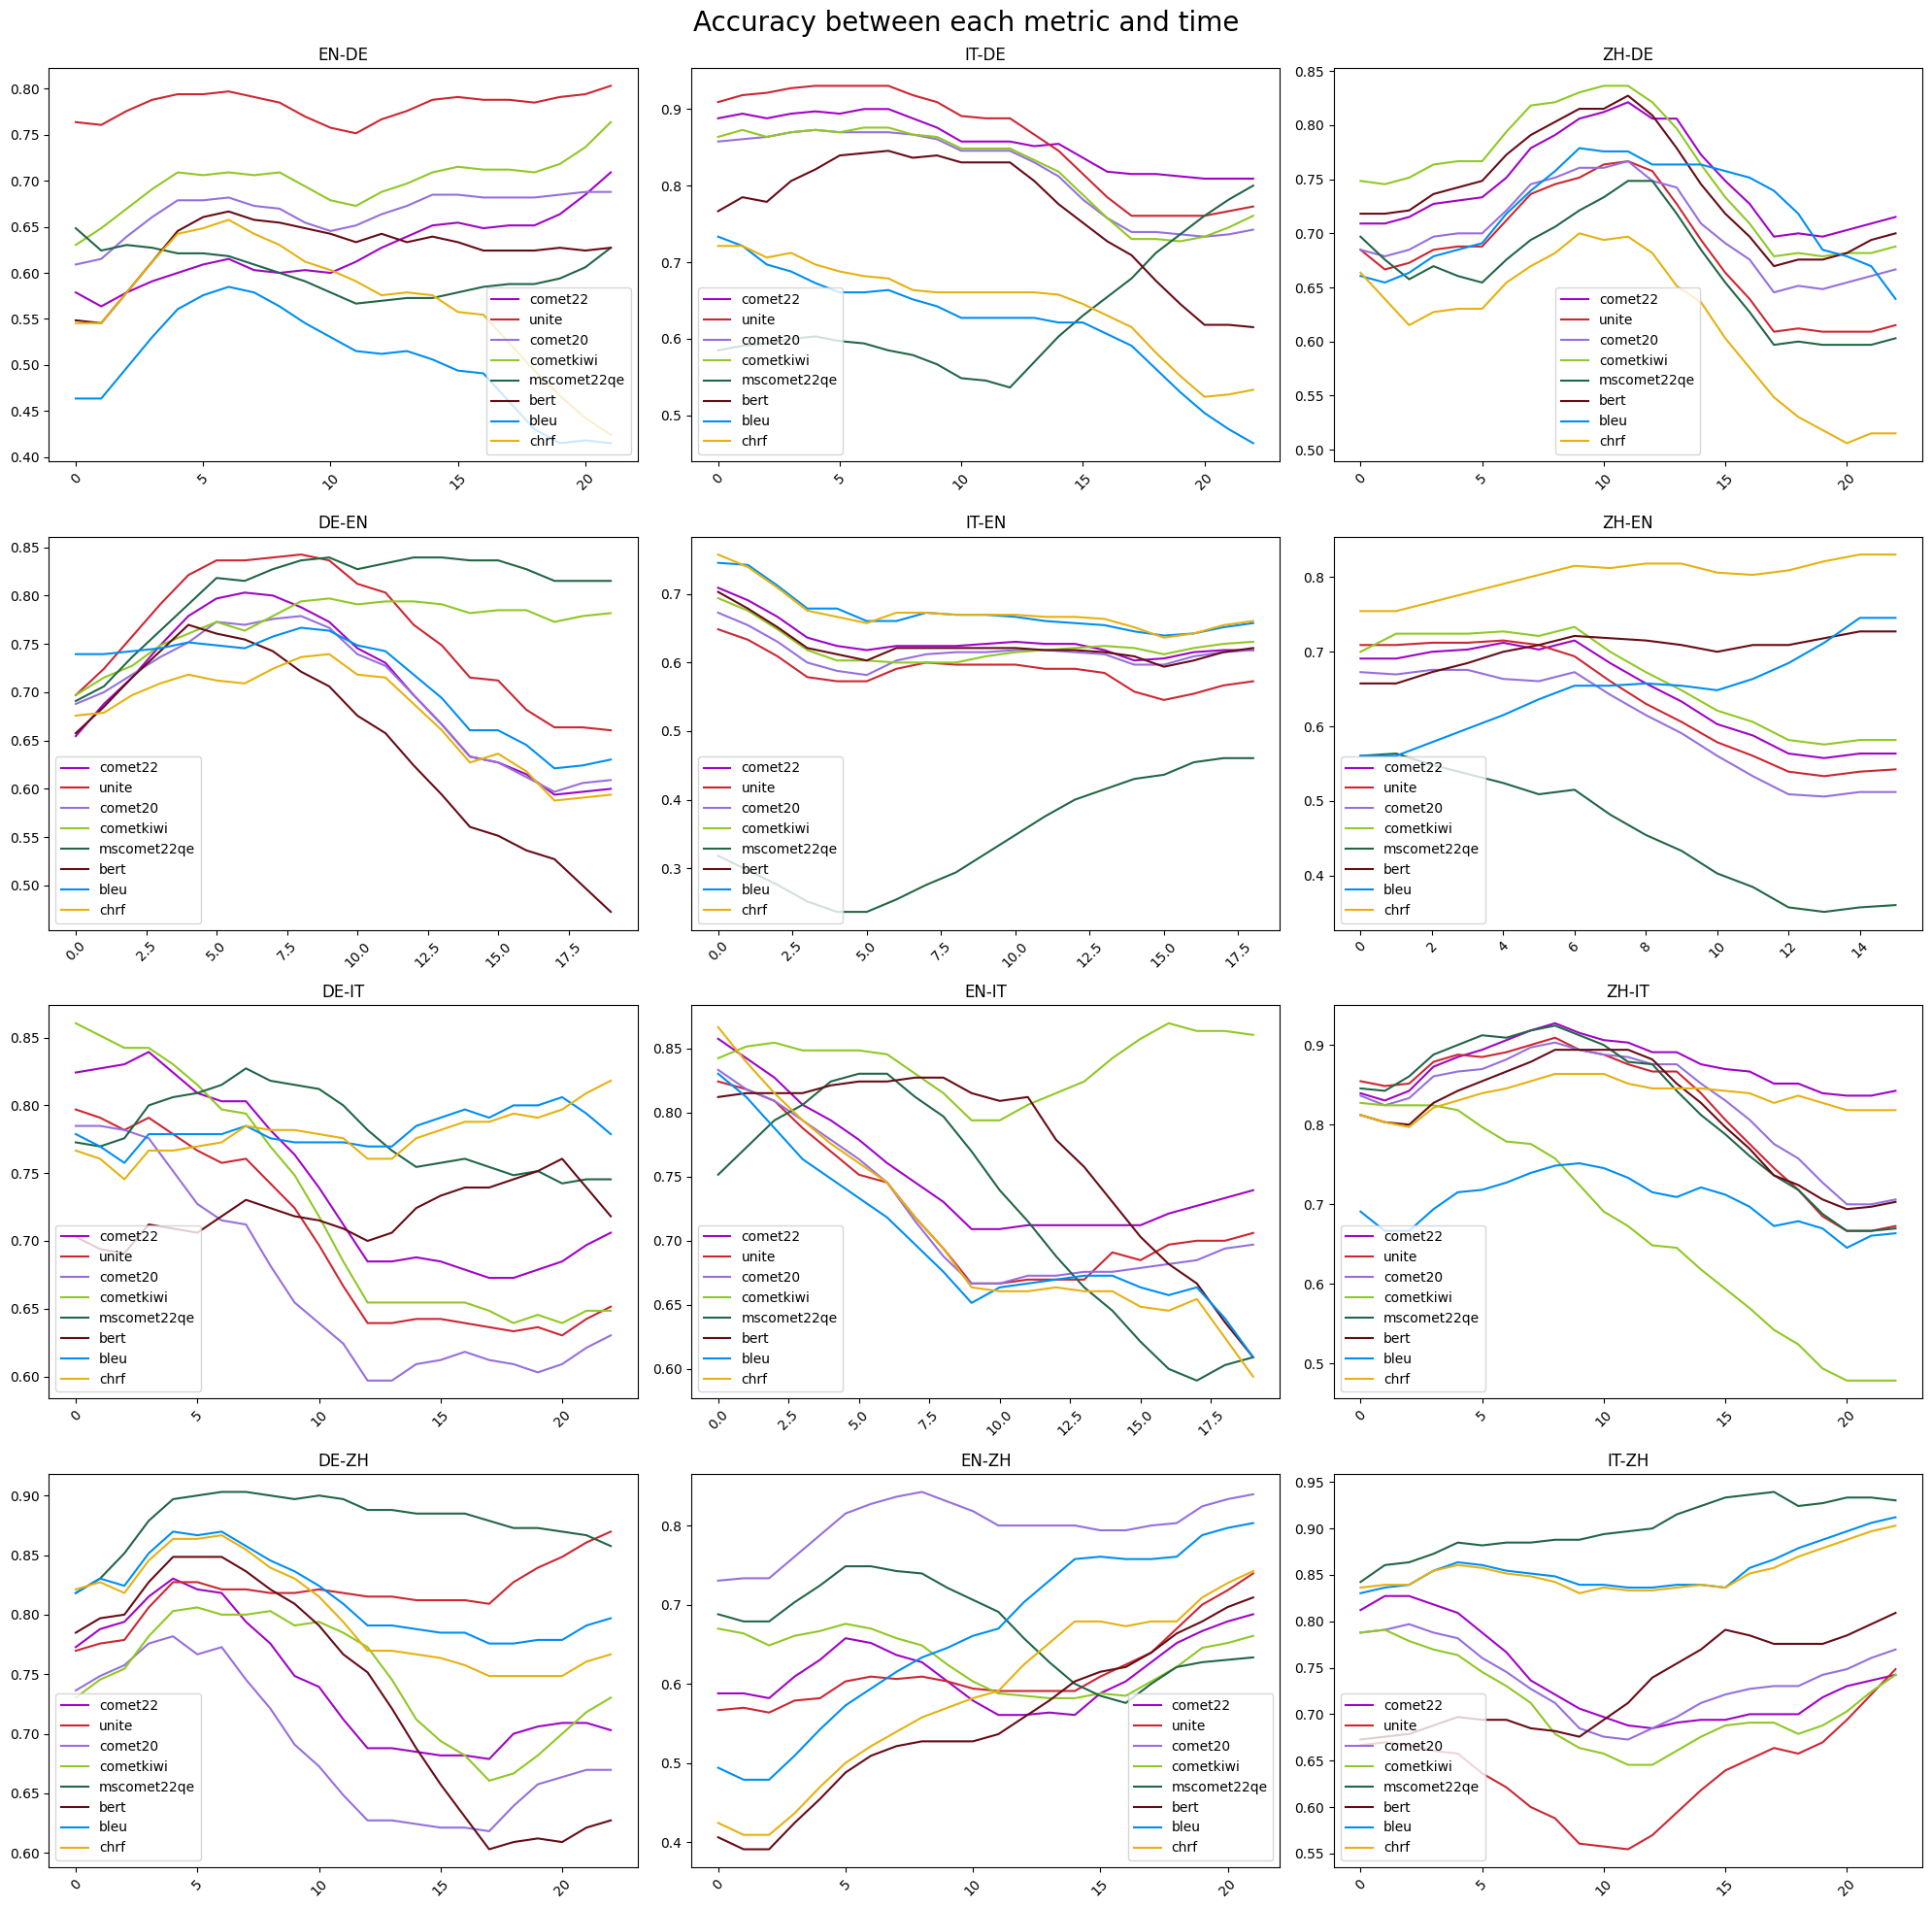

In [2]:
from evaluation.util import *

correlations, corr_name = rolling(gap=11, sample_size=36)
draw_roll(correlations, corr_name)

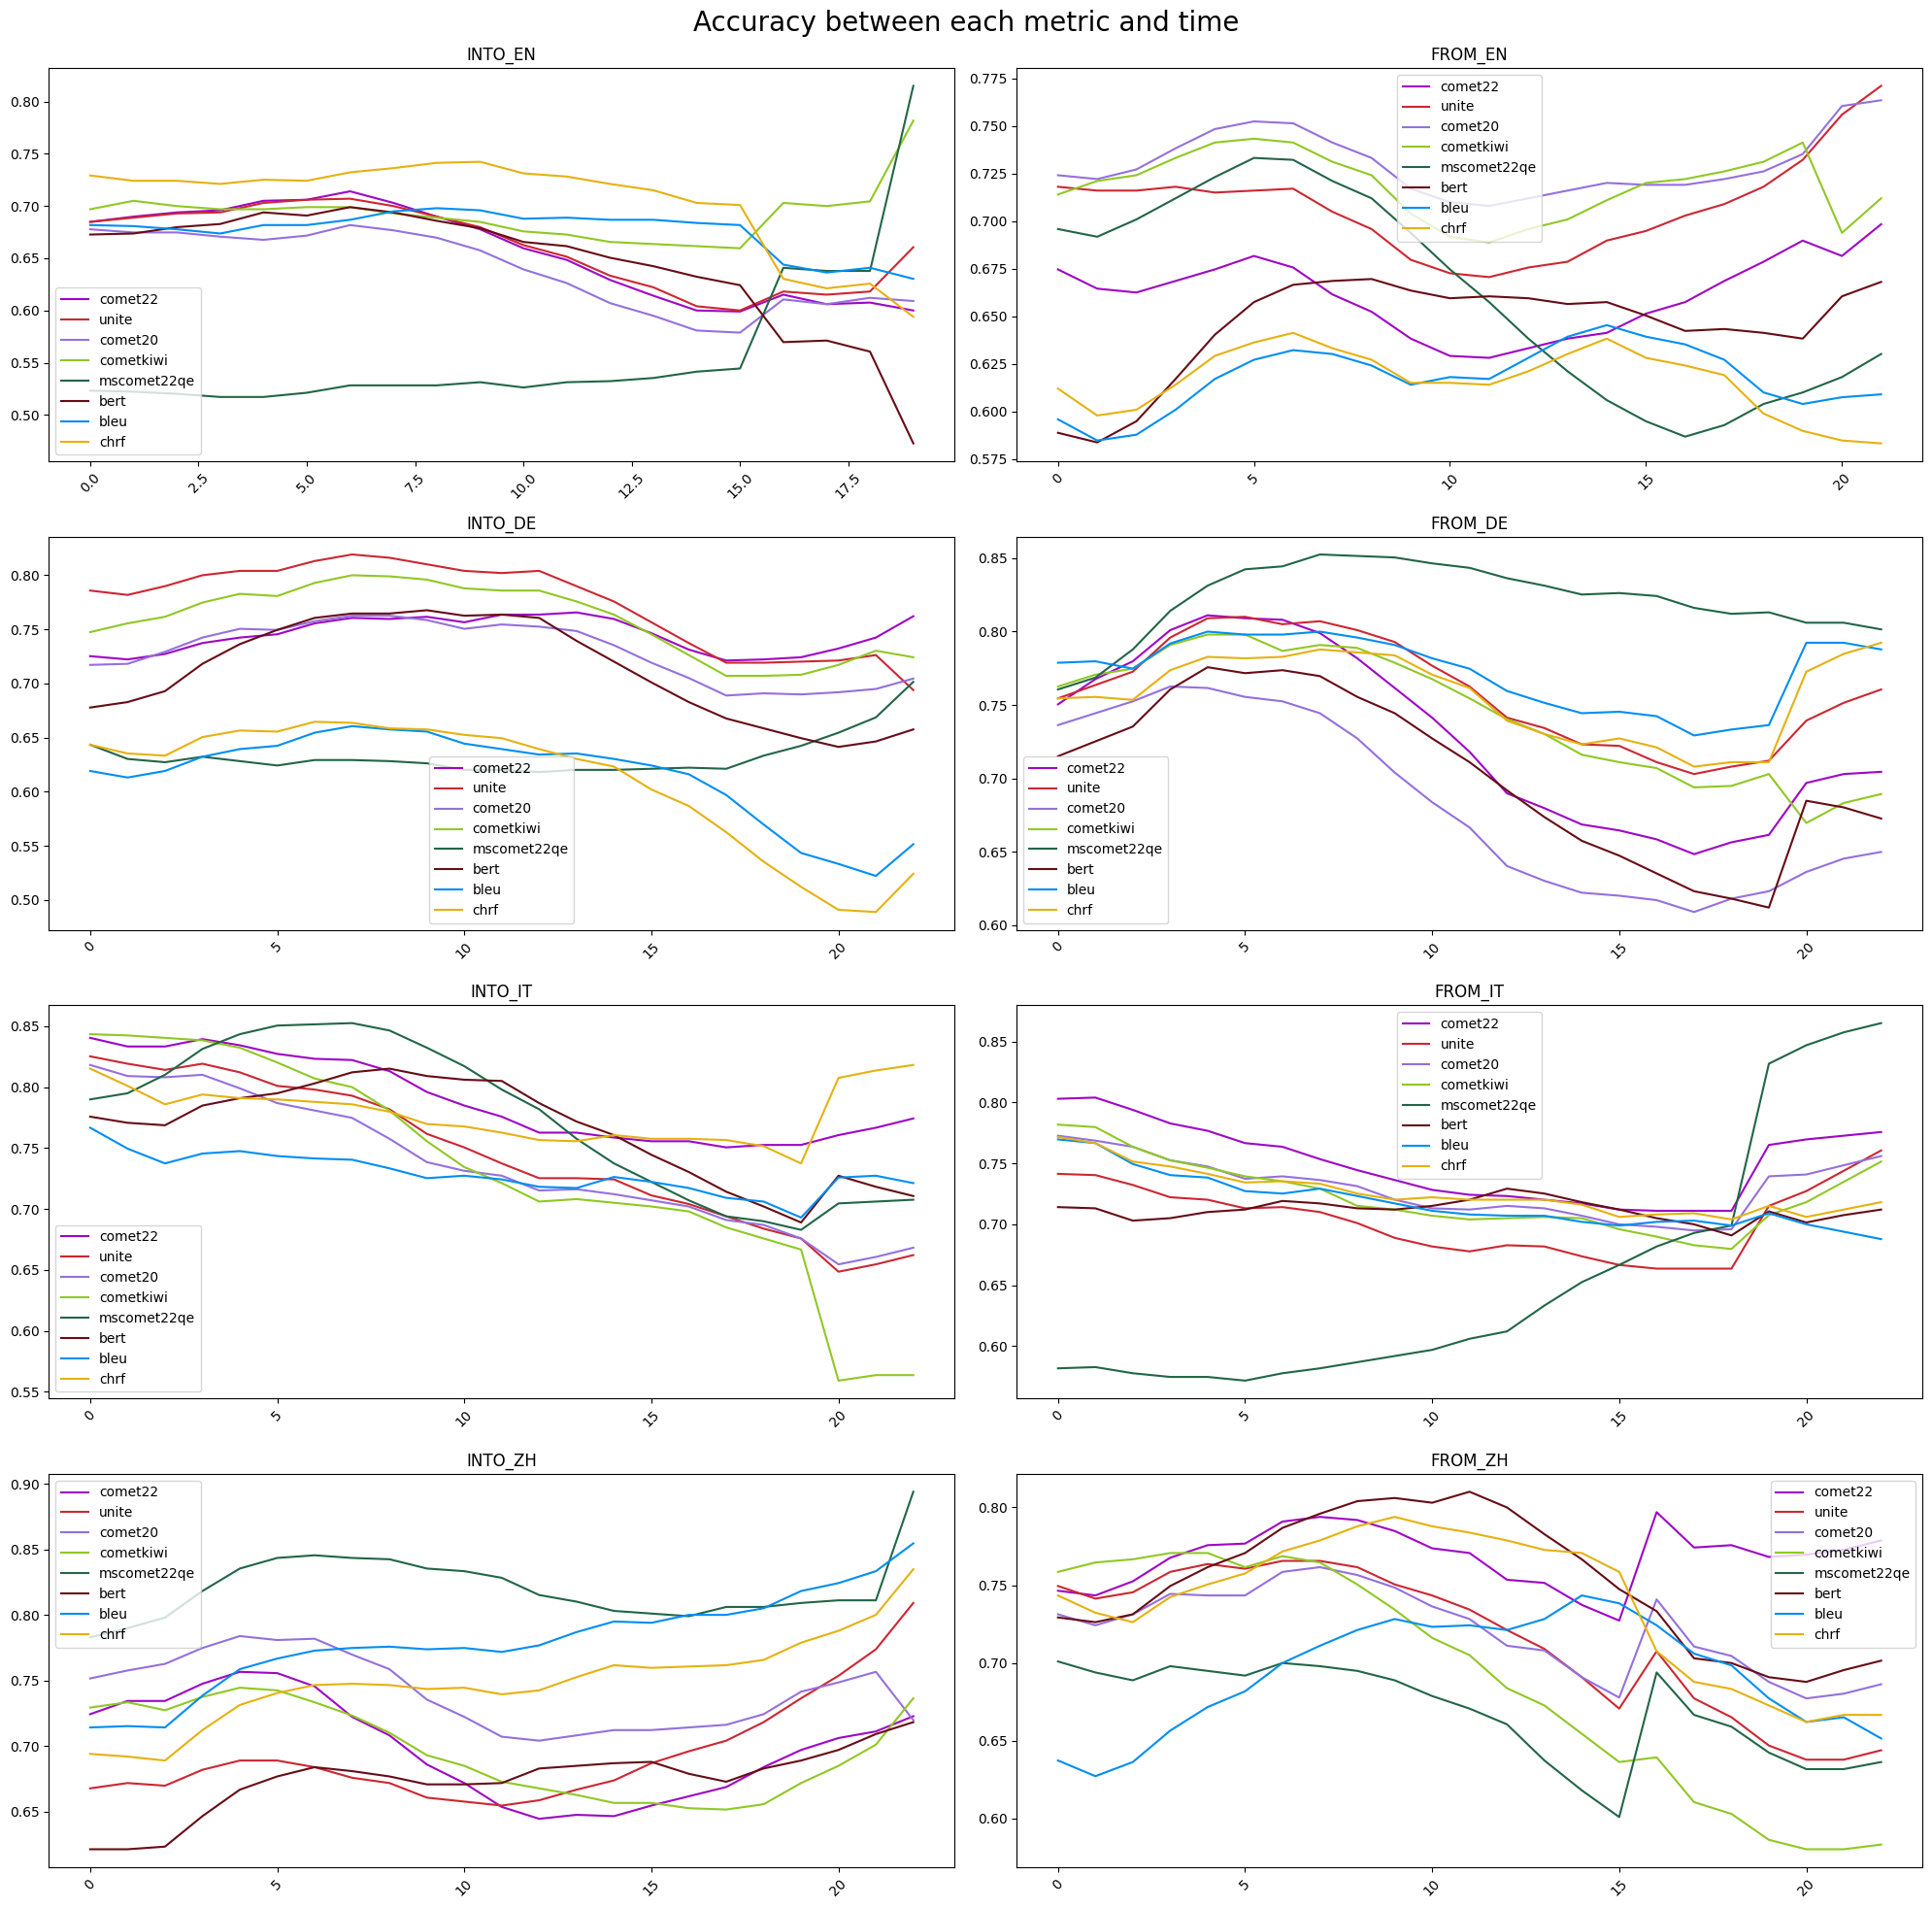

In [3]:
draw_roll_subset(correlations, corr_name)

# DeepL

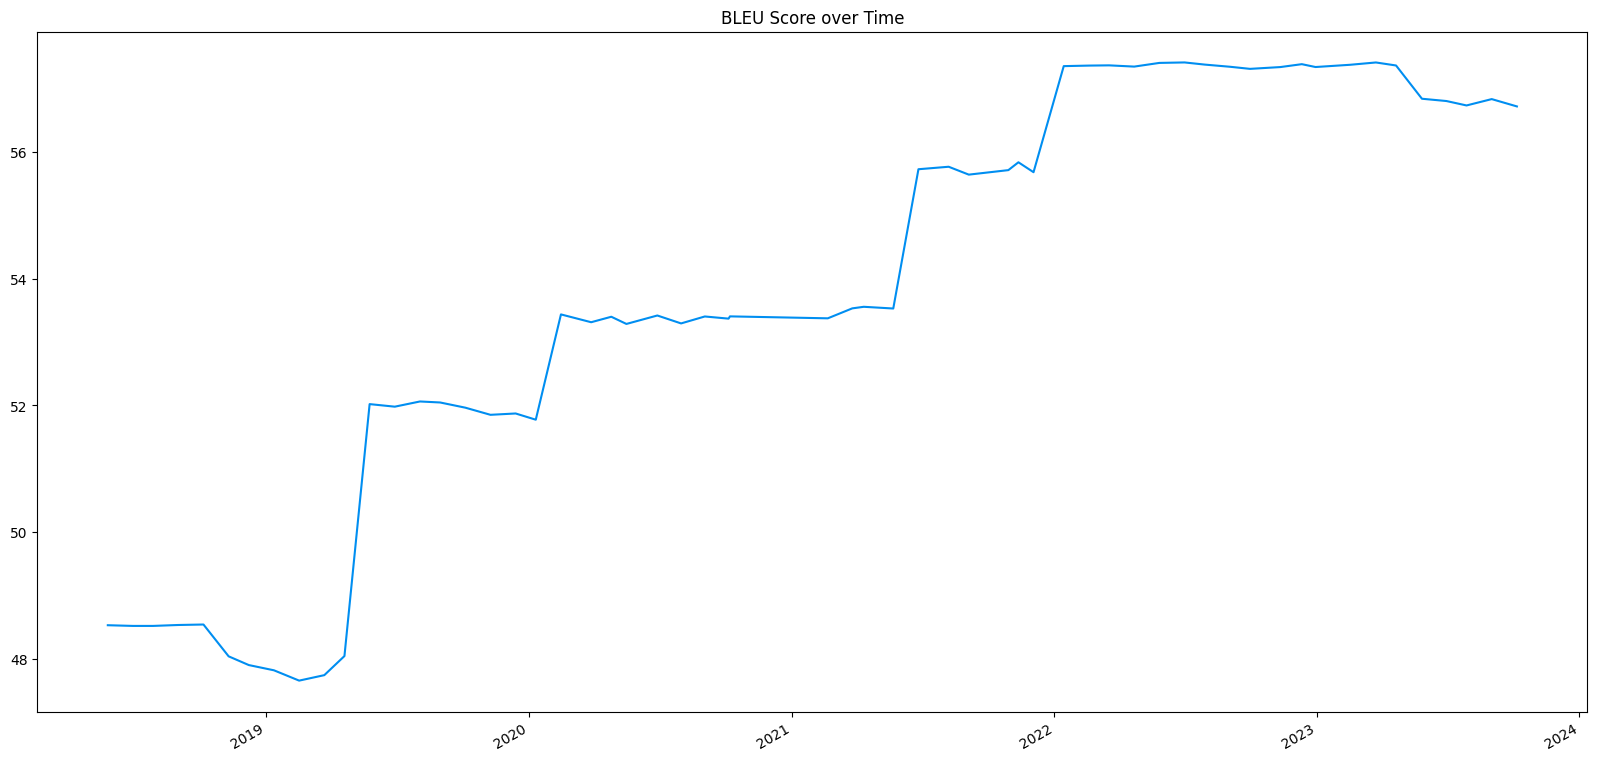

In [21]:
import pandas as pd
metric = 'bleu'
deep_lp = 'en-de'
df = pd.read_csv(f'deepl/{metric}/sys_{deep_lp}.csv')

# plot the score over time
from evaluation.SETTINGS import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# date is in the format of '2018-05-26'
date_objs = [datetime.strptime(date, '%Y-%m-%d') for date in df['date']]
formatted_dates = [date_obj.strftime('%Y-%m-%d') for date_obj in date_objs]

df['date'] = pd.to_datetime(formatted_dates)
df = df.set_index('date')

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(ax=ax, color=colors[metric], legend=False)
ax.set_title(metric_dict[metric]+' Score over Time')
ax.set_xlabel(None)
ax.set_ylabel(None)

# show the figure
plt.show()

In [22]:
from evaluation.util import acc, get_deep_lp
import numpy as np
deep_lps = ['en-de', 'en-zh', 'zh-en']
deep_metrics = ['bleu', 'chrf', 'bert', 'comet20', 'unite', 'comet22']
acc_dict = {}
for deep_lp in deep_lps:
    for metric in deep_metrics:
        df = get_deep_lp(deep_lp, metric)
        human_acc = acc(df['human'], gap=11)
        deepl_acc = acc(df['deepl'], gap=11)
        human_acc = np.sum(human_acc) / len(human_acc)
        deepl_acc = np.sum(deepl_acc) / len(deepl_acc)
        acc_dict[(deep_lp, metric)] = (human_acc, deepl_acc)

acc_df = pd.DataFrame(acc_dict).T
acc_df.columns = ['Human', 'DeepL']
acc_df

Human     DeepL
en-de bleu     0.477718  0.655971
      chrf     0.527629  0.811052
      bert     0.655971  0.725490
      comet20  0.721925  0.852050
      unite    0.803922  0.853832
      comet22  0.713012  0.852050
en-zh bleu     0.613191  0.645276
      chrf     0.568627  0.689840
      bert     0.545455  0.670232
      comet20  0.780749  0.648841
      unite    0.663102  0.639929
      comet22  0.645276  0.611408
zh-en bleu     0.680808  0.688889
      chrf     0.808081  0.808081
      bert     0.741414  0.648485
      comet20  0.616162  0.670707
      unite    0.626263  0.650505
      comet22  0.636364  0.652525

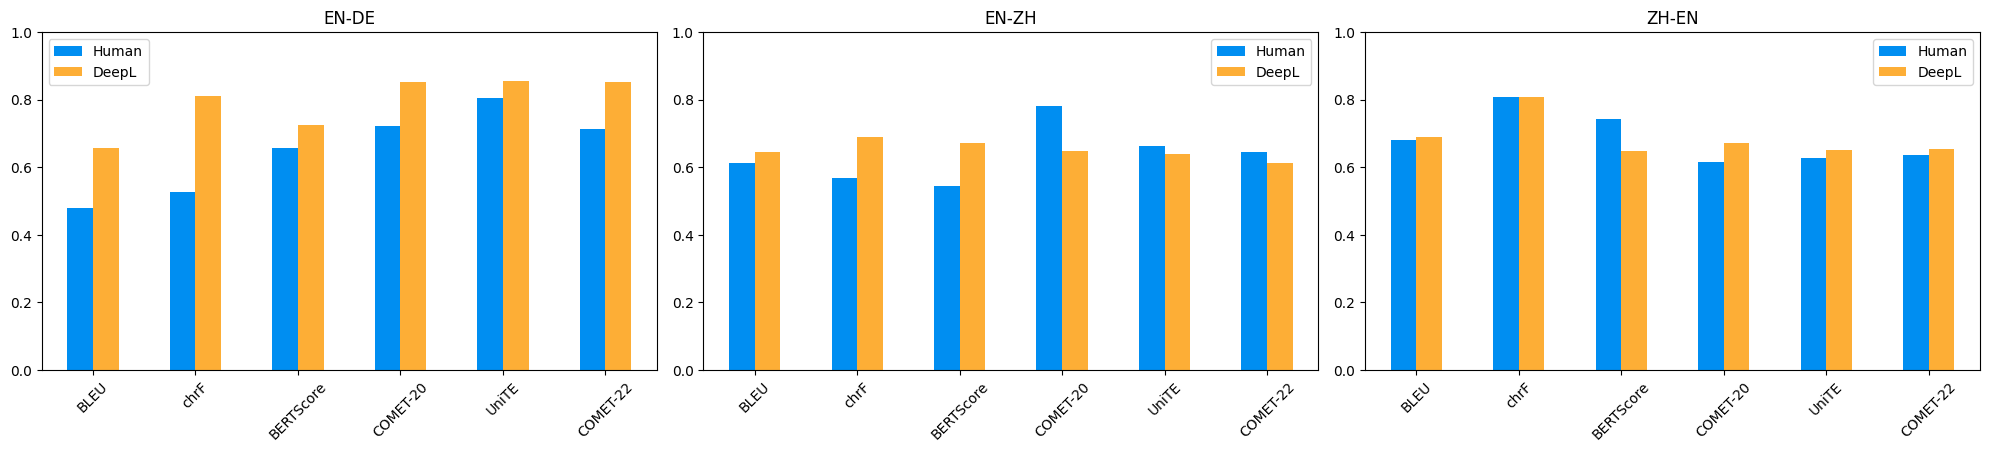

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

for i, ax in enumerate(axes.flatten()):
    deep_lp = deep_lps[i]
    df = acc_df.loc[deep_lp]
    df.plot(kind='bar', ax=ax, color=[colors['human'], colors['deepl']])
    ax.set_title(deep_lp.upper())
    ax.set_xlabel(None)
    if i == 0:
        # ax.set_ylabel('Accuracy')
        ax.legend(['Human', 'DeepL'], loc='upper left')
    ax.set_ylim(0, 1)
    
    # for x tick labels replace the deep metrics with the full name using the metric_dict
    ax.set_xticklabels([metric_dict[metric] for metric in deep_metrics], rotation=45)

fig.tight_layout()
fig.subplots_adjust(top=0.85)

plt.show()